# Final Experimentation Notebook

In terms of the implementation of these two metrics, the maintainers of TensorFlow
provide a convenient out-of-the-box implementation of both IS and FID in their TF-
GAN package. In terms of the evaluation process, I first will split the CIFAR-10 data
into train and test as the test data is needed for evaluation purposes with FID. I will then
train 4 GANs and 4 VAEs on the training data. The models that will be tested will use
the following architectures: transposed convolution, upscaling convolution, conditional
transposed convolution, and conditional upscaling convolution. In terms of model size,
all GANs and VAEs respectively will be very similar if not the same size to prevent bias
from being introduced. Lastly, all 8 models will generate 200 to 400 random images and
will be processed using both FID and IS

In summary
- Will be evaluating the performance of 8 models
   - Transposed convolution GAN / VAE
   - Upscaling convolution GAN / VAE
   - Transposed convolution conditional GAN / VAE
   - Upscaling convolution conditional GAN / VAE
- For each class of model (GAN or VAE) will try to force the architecture to be the same
- Will use FID and IS to evaluate the models

### Imports

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import time

In [4]:
batch_size = 100

### Load in Data

In [3]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

all_images = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_images = all_images.astype("float32") / 255.0
all_labels = keras.utils.to_categorical(all_labels, 10)

dataset = tf.data.Dataset.from_tensor_slices((all_images))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_images.shape}")
print(f"Shape of training labels: {all_labels.shape}")

2023-04-17 12:53:34.403369: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 12:53:34.965311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


Shape of training images: (60000, 32, 32, 3)
Shape of training labels: (60000, 10)


# Transposed Convolution Models

## GAN

In [22]:
latent_dim = 110

In [23]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((32, 32, 3)),
     
        layers.Conv2D(62, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
     
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((latent_dim,)),
        layers.Dense(4 * 4 * latent_dim * 2),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Reshape((4, 4, latent_dim * 2)),
     
        layers.Conv2DTranspose(192, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2DTranspose(96, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2DTranspose(48, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2D(3, (4, 4), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [24]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [25]:
from matplotlib import pyplot

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if(epoch % 10 == 0):
            for i in range(49):
                random_latent_vectors = tf.random.normal(shape=(49, 110))
                generated_image = gan1.generator(random_latent_vectors)
                generated_image.numpy()
                # define subplot
                pyplot.subplot(7, 7, 1 + i)
                # turn off axis
                pyplot.axis('off')
                # plot raw pixel data
                pyplot.imshow(generated_image[i])
            # save plot to file
            filename = "generated_img_%03d_und_trans_conv_gan.png" % (epoch)
            pyplot.savefig(filename)
            pyplot.close()

In [26]:

gan1 = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan1.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

epochs = 100

gan1.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(latent_dim=latent_dim)]
)

Epoch 1/100
600/600 [==============================] - 6s 9ms/step - d_loss: 0.6178 - g_loss: 1.0355
Epoch 2/100
600/600 [==============================] - 5s 8ms/step - d_loss: 0.6653 - g_loss: 0.8726
Epoch 3/100
600/600 [==============================] - 5s 8ms/step - d_loss: 0.6648 - g_loss: 0.8688
Epoch 4/100
600/600 [==============================] - 5s 8ms/step - d_loss: 0.6681 - g_loss: 0.8660
Epoch 5/100
600/600 [==============================] - 5s 8ms/step - d_loss: 0.6802 - g_loss: 0.8314
Epoch 6/100
600/600 [==============================] - 5s 8ms/step - d_loss: 0.6763 - g_loss: 0.8295
Epoch 7/100
600/600 [==============================] - 5s 8ms/step - d_loss: 0.6768 - g_loss: 0.8358
Epoch 8/100
600/600 [==============================] - 5s 8ms/step - d_loss: 0.6716 - g_loss: 0.8475
Epoch 9/100
600/600 [==============================] - 5s 8ms/step - d_loss: 0.6624 - g_loss: 0.8933
Epoch 10/100
600/600 [==============================] - 5s 8ms/step - d_loss: 0.6663 - g_lo

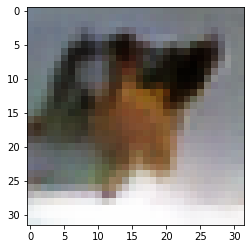

tf.Tensor([[0.49180132]], shape=(1, 1), dtype=float32)


In [29]:
def sampleGan():
    random_latent_vectors = tf.random.normal(shape=(1, 110))
    generated_image = gan1.generator(random_latent_vectors)
    generated_image.numpy()
    plt.imshow(generated_image[0])
    plt.show()
    print(gan1.discriminator(generated_image))
sampleGan()

In [30]:
from matplotlib import pyplot

def save_plot():
    random_latent_vectors = tf.random.normal(shape=(49, 110))
    generated_image = gan1.generator(random_latent_vectors)
    generated_image.numpy()
    for i in range(49):
        # define subplot
        pyplot.subplot(7, 7, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(generated_image[i])
    # save plot to file
    filename = 'generated_plot.png'
    pyplot.savefig(filename)
    pyplot.close()
save_plot()

In [31]:
gan1.generator.save("un_trans_conv_gan")

INFO:tensorflow:Assets written to: un_trans_conv_gan/assets


## VAE

In [32]:
latent_dim=110

In [33]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2))(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 32, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 32))(x)

x = layers.Conv2DTranspose(192, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(96, (4, 4), strides=(2, 2), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

decoder_outputs = layers.Conv2D(3, (4, 4), padding='same', activation="sigmoid", use_bias=False)(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [34]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [37]:
class VAEMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if(epoch % 10 == 0):
            for i in range(49):
                random_latent_vectors = tf.random.normal(shape=(49, self.latent_dim))
                generated_image = vae1.decoder(random_latent_vectors)
                generated_image.numpy()
                # define subplot
                pyplot.subplot(7, 7, 1 + i)
                # turn off axis
                pyplot.axis('off')
                # plot raw pixel data
                pyplot.imshow(generated_image[i])
            # save plot to file
            filename = "generated_img_%03d_und_trans_conv_vae.png" % (epoch)
            pyplot.savefig(filename)
            pyplot.close()

In [38]:
vae1 = VAE(encoder, decoder)
vae1.compile(optimizer=keras.optimizers.Adam())
vae1.fit(dataset, epochs=100, batch_size=100, callbacks=[VAEMonitor(latent_dim=latent_dim)])

Epoch 1/100
600/600 [==============================] - 5s 8ms/step - loss: 661.3050 - reconstruction_loss: 644.6620 - kl_loss: 10.8329
Epoch 2/100
600/600 [==============================] - 4s 7ms/step - loss: 649.5977 - reconstruction_loss: 637.9694 - kl_loss: 10.7615
Epoch 3/100
600/600 [==============================] - 4s 6ms/step - loss: 645.3266 - reconstruction_loss: 634.2410 - kl_loss: 10.6174
Epoch 4/100
600/600 [==============================] - 4s 6ms/step - loss: 642.1618 - reconstruction_loss: 631.9382 - kl_loss: 10.1601
Epoch 5/100
600/600 [==============================] - 4s 6ms/step - loss: 640.6592 - reconstruction_loss: 630.7784 - kl_loss: 9.8709
Epoch 6/100
600/600 [==============================] - 4s 6ms/step - loss: 639.4352 - reconstruction_loss: 629.5911 - kl_loss: 9.9377
Epoch 7/100
600/600 [==============================] - 4s 6ms/step - loss: 638.5654 - reconstruction_loss: 628.7861 - kl_loss: 9.9879
Epoch 8/100
600/600 [==============================] - 4s 

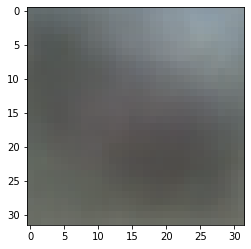

In [40]:
import matplotlib.pyplot as plt


def sampleVae():   
    random_latent_vectors = tf.random.normal(shape=(1, 110))
    generated_image = vae1.decoder(random_latent_vectors)
    generated_image.numpy()
    plt.imshow(generated_image[0])
    plt.show()

sampleVae()

In [41]:
vae1.decoder.save("un_trans_conv_vae")

INFO:tensorflow:Assets written to: un_trans_conv_vae/assets


# Upscaling Convolution Models

## GAN

In [42]:
latent_dim = 110

In [43]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((32, 32, 3)),
     
        layers.Conv2D(62, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
     
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((latent_dim,)),
        layers.Dense(4 * 4 * latent_dim * 2),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Reshape((4, 4, latent_dim * 2)),
     
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(192, (4, 4), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
     
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(96, (4, 4), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
     
        layers.UpSampling2D(size=(2, 2)),   
        layers.Conv2D(48, (4, 4), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2D(3, (4, 4), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [44]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [45]:
from matplotlib import pyplot

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if(epoch % 10 == 0):
            for i in range(49):
                random_latent_vectors = tf.random.normal(shape=(49, 110))
                generated_image = gan2.generator(random_latent_vectors)
                generated_image.numpy()
                # define subplot
                pyplot.subplot(7, 7, 1 + i)
                # turn off axis
                pyplot.axis('off')
                # plot raw pixel data
                pyplot.imshow(generated_image[i])
            # save plot to file
            filename = "generated_img_%03d_ups_conv_gan.png" % (epoch)
            pyplot.savefig(filename)
            pyplot.close()

In [46]:

gan2 = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan2.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

epochs = 100

gan2.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(latent_dim=latent_dim)]
)

Epoch 1/100
600/600 [==============================] - 9s 14ms/step - d_loss: 0.6697 - g_loss: 0.8803
Epoch 2/100
600/600 [==============================] - 7s 11ms/step - d_loss: 0.6859 - g_loss: 0.7884
Epoch 3/100
600/600 [==============================] - 7s 11ms/step - d_loss: 0.6873 - g_loss: 0.7808
Epoch 4/100
600/600 [==============================] - 7s 11ms/step - d_loss: 0.6879 - g_loss: 0.7902
Epoch 5/100
600/600 [==============================] - 7s 11ms/step - d_loss: 0.6842 - g_loss: 0.8023
Epoch 6/100
600/600 [==============================] - 7s 11ms/step - d_loss: 0.6827 - g_loss: 0.8140
Epoch 7/100
600/600 [==============================] - 7s 11ms/step - d_loss: 0.6835 - g_loss: 0.8236
Epoch 8/100
600/600 [==============================] - 7s 11ms/step - d_loss: 0.6830 - g_loss: 0.8170
Epoch 9/100
600/600 [==============================] - 7s 11ms/step - d_loss: 0.6877 - g_loss: 0.7940
Epoch 10/100
600/600 [==============================] - 7s 11ms/step - d_loss: 0.6

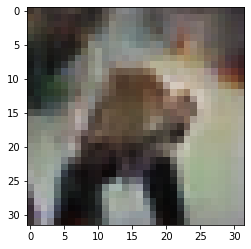

tf.Tensor([[0.5250594]], shape=(1, 1), dtype=float32)


In [47]:
def sampleGan():
    random_latent_vectors = tf.random.normal(shape=(1, 110))
    generated_image = gan2.generator(random_latent_vectors)
    generated_image.numpy()
    plt.imshow(generated_image[0])
    plt.show()
    print(gan1.discriminator(generated_image))
sampleGan()

In [48]:
from matplotlib import pyplot

def save_plot():
    random_latent_vectors = tf.random.normal(shape=(49, 110))
    generated_image = gan2.generator(random_latent_vectors)
    generated_image.numpy()
    for i in range(49):
        # define subplot
        pyplot.subplot(7, 7, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(generated_image[i])
    # save plot to file
    filename = 'generated_plot.png'
    pyplot.savefig(filename)
    pyplot.close()
save_plot()

In [49]:
gan2.generator("un_upsc_conv_gan")

TypeError: Inputs to a layer should be tensors. Got: un_upsc_conv_gan

## VAE

In [4]:
latent_dim=110

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2))(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 32, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 32))(x)

x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(192, (4, 4), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(96, (4, 4), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

decoder_outputs = layers.Conv2D(3, (4, 4), padding='same', activation="sigmoid", use_bias=False)(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [9]:
from matplotlib import pyplot

class VAEMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if(epoch % 10 == 0):
            for i in range(49):
                random_latent_vectors = tf.random.normal(shape=(49, self.latent_dim))
                generated_image = vae2.decoder(random_latent_vectors)
                generated_image.numpy()
                # define subplot
                pyplot.subplot(7, 7, 1 + i)
                # turn off axis
                pyplot.axis('off')
                # plot raw pixel data
                pyplot.imshow(generated_image[0])
            # save plot to file
            filename = "generated_img_%03d_upscs_conv_vae.png" % (epoch)
            pyplot.savefig(filename)
            pyplot.close()

In [10]:
vae2 = VAE(encoder, decoder)
vae2.compile(optimizer=keras.optimizers.Adam())
vae2.fit(dataset, epochs=100, batch_size=100, callbacks=[VAEMonitor(latent_dim=latent_dim)])

Epoch 1/100
600/600 [==============================] - 8s 12ms/step - loss: 658.4127 - reconstruction_loss: 640.5021 - kl_loss: 11.6475
Epoch 2/100
600/600 [==============================] - 6s 10ms/step - loss: 645.1016 - reconstruction_loss: 631.7379 - kl_loss: 12.2064
Epoch 3/100
600/600 [==============================] - 6s 9ms/step - loss: 639.2180 - reconstruction_loss: 626.0164 - kl_loss: 12.5506
Epoch 4/100
600/600 [==============================] - 6s 9ms/step - loss: 636.5720 - reconstruction_loss: 624.0240 - kl_loss: 12.5373
Epoch 5/100
600/600 [==============================] - 6s 10ms/step - loss: 635.5247 - reconstruction_loss: 622.8767 - kl_loss: 12.6670
Epoch 6/100
600/600 [==============================] - 6s 10ms/step - loss: 634.6409 - reconstruction_loss: 622.1877 - kl_loss: 12.6941
Epoch 7/100
600/600 [==============================] - 6s 10ms/step - loss: 634.0595 - reconstruction_loss: 621.5441 - kl_loss: 12.7136
Epoch 8/100
600/600 [=============================

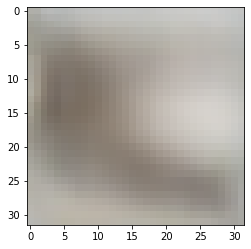

In [16]:
import matplotlib.pyplot as plt


def sampleVae():   
    random_latent_vectors = tf.random.normal(shape=(1, 110))
    generated_image = vae2.decoder(random_latent_vectors)
    generated_image.numpy()
    plt.imshow(generated_image[0])
    plt.show()

sampleVae()

In [17]:
vae2.decoder.save("un_upsc_conv_vae")

2023-04-17 13:05:38.477541: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: un_upsc_conv_vae/assets


# Load in data

In [12]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

all_images = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_images = all_images.astype("float32") / 255.0
all_labels = keras.utils.to_categorical(all_labels, 10)

dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_images.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (60000, 32, 32, 3)
Shape of training labels: (60000, 10)


# Conditional Transposed Convolution Models

## GAN

In [11]:
batch_size = 100
num_channels = 3
num_classes = 10
image_size = 32
latent_dim = 110

In [12]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

120 13


In [13]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((32, 32, discriminator_in_channels)),
     
        layers.Conv2D(62, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),


        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),

        layers.Dense(4 * 4 * generator_in_channels * 2),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Reshape((4, 4, generator_in_channels * 2)),
     
        tf.keras.layers.Conv2DTranspose(192, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),


        tf.keras.layers.Conv2DTranspose(96, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        
        tf.keras.layers.Conv2DTranspose(48, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

     
        layers.Conv2DTranspose(3, (4, 4), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [14]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [15]:
from matplotlib import pyplot
import random
class CGANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if(epoch % 10 == 0):
            for i in range(49):
                trained_gen = cond_gan.generator
                noise = tf.random.normal(shape=(1, latent_dim))
                label = keras.utils.to_categorical([random.randint(0, 9)], 10)
                noise_and_labels = tf.concat([noise, label], 1)
                generated_image = trained_gen.predict(noise_and_labels)
                # define subplot
                pyplot.subplot(7, 7, 1 + i)
                # turn off axis
                pyplot.axis('off')
                # plot raw pixel data
                pyplot.imshow(generated_image[0])
            # save plot to file
            filename = "generated_img_%03d_cond_trans_conv_gan.png" % (epoch)
            pyplot.savefig(filename)
            pyplot.close()

In [16]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

cond_gan.fit(dataset, epochs=100, callbacks=[CGANMonitor(latent_dim=latent_dim)])

Epoch 1/100
600/600 [==============================] - 8s 11ms/step - g_loss: 1.0027 - d_loss: 0.6223
Epoch 2/100
600/600 [==============================] - 5s 8ms/step - g_loss: 0.9254 - d_loss: 0.6568
Epoch 3/100
600/600 [==============================] - 5s 8ms/step - g_loss: 0.8400 - d_loss: 0.6785
Epoch 4/100
600/600 [==============================] - 5s 8ms/step - g_loss: 0.8393 - d_loss: 0.6753
Epoch 5/100
600/600 [==============================] - 5s 8ms/step - g_loss: 0.8274 - d_loss: 0.6751
Epoch 6/100
600/600 [==============================] - 5s 8ms/step - g_loss: 0.8486 - d_loss: 0.6691
Epoch 7/100
600/600 [==============================] - 5s 8ms/step - g_loss: 0.8465 - d_loss: 0.6700
Epoch 8/100
600/600 [==============================] - 5s 8ms/step - g_loss: 0.8594 - d_loss: 0.6691
Epoch 9/100
600/600 [==============================] - 5s 8ms/step - g_loss: 0.8531 - d_loss: 0.6742
Epoch 10/100
600/600 [==============================] - 5s 8ms/step - g_loss: 0.8437 - d_l

In [17]:
def sampleCondGan(class_num):
    trained_gen = cond_gan.generator
    noise = tf.random.normal(shape=(1, latent_dim))
    label = keras.utils.to_categorical([class_num], 10)
    noise_and_labels = tf.concat([noise, label], 1)
    fake = trained_gen.predict(noise_and_labels)
    plt.imshow(fake[0])
    plt.show()

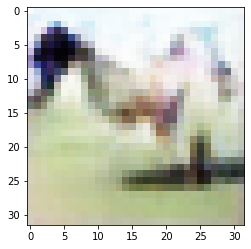

In [61]:
sampleCondGan(7)

In [48]:
cond_gan.generator.save("trans-cond-gan")

INFO:tensorflow:Assets written to: trans-cond-gan/assets


## VAE

In [ ]:
batch_size = 32
num_channels = 3
num_classes = 10
image_size = 32
latent_dim = 128

In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

In [ ]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=((32, 32, discriminator_in_channels))),

            tf.keras.layers.Conv2D(
                filters=32, kernel_size=4, strides=(2, 2), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(
                filters=32, kernel_size=4, strides=(2, 2), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(
                filters=32, kernel_size=4, strides=(2, 2), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            # No activation
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
            tf.keras.layers.Reshape(target_shape=(latent_dim * 2,)),
        ]
        )


        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim + num_classes,)),
            tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(8, 8, 32)),  

            tf.keras.layers.Conv2DTranspose(192, (4, 4), strides=(2, 2), padding='same', activation='relu'),
            layers.BatchNormalization(),

            tf.keras.layers.Conv2DTranspose(96, (4, 4), strides=(2, 2), padding='same', activation='relu'),
            layers.BatchNormalization(),

            # No activation
            tf.keras.layers.Conv2D(3, (4, 4), padding='same', use_bias=False)
        ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(1, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x, real, one_hot_labels):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    z_comb = tf.concat([z, one_hot_labels], 1)
    x_logit = model.decode(z_comb)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=real)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, batch, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """

    real_images, one_hot_labels = batch


    image_one_hot_labels = one_hot_labels[:, :, None, None]
    image_one_hot_labels = tf.repeat(
      image_one_hot_labels, repeats=[image_size * image_size]
    )
    image_one_hot_labels = tf.reshape(
      image_one_hot_labels, (-1, image_size, image_size, num_classes)
    )
    X = tf.concat([real_images, image_one_hot_labels], -1)
    with tf.GradientTape() as tape:
        loss = compute_loss(model, X, real_images, one_hot_labels)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
epochs = 100
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 110

model = CVAE(latent_dim)

In [ ]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for batch in dataset: 
        train_step(model, batch, optimizer)
    end_time = time.time()
    print('Epoch: {}, time elapse for current epoch: {}'
    .format(epoch, end_time - start_time))

In [ ]:
def sampleCondVae():
    z = tf.random.normal(shape=(1, latent_dim))
    conditioned_array = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    conditioned_array = np.expand_dims(conditioned_array, axis=0)
    z_comb = tf.concat([z, conditioned_array], 1)
    picture = model.sample(z_comb)[0]
    plt.imshow(picture)
    plt.show()

In [ ]:
sampleCondVae()

In [ ]:
model.decoder.save("trans-cond-vae")

# Conditional Upscaling Convolution

## GAN

In [5]:
batch_size = 100
num_channels = 3
num_classes = 10
image_size = 32
latent_dim = 110

In [6]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

120 13


In [8]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((32, 32, discriminator_in_channels)),

        layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2D(256, (4, 4), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Flatten(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(4 * 4 * generator_in_channels * 2),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Reshape((4, 4, generator_in_channels * 2)),
     
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(192, (4, 4), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),


        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(96, (4, 4), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        layers.UpSampling2D(size=(2, 2)),
        layers.Conv2D(48, (4, 4), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
     
        layers.Conv2D(3, (4, 4), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [9]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [14]:
from matplotlib import pyplot
import random
class CGANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if(epoch % 10 == 0):
            for i in range(49):
                trained_gen = cond_gan1.generator
                noise = tf.random.normal(shape=(1, latent_dim))
                label = keras.utils.to_categorical([random.randint(0, 9)], 10)
                noise_and_labels = tf.concat([noise, label], 1)
                generated_image = trained_gen.predict(noise_and_labels)
                # define subplot
                pyplot.subplot(7, 7, 1 + i)
                # turn off axis
                pyplot.axis('off')
                # plot raw pixel data
                pyplot.imshow(generated_image[0])
            # save plot to file
            filename = "generated_img_%03d_cond_upsc_conv_gan.png" % (epoch)
            pyplot.savefig(filename)
            pyplot.close()

In [15]:
cond_gan1 = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan1.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan1.fit(dataset, epochs=100, callbacks=[CGANMonitor(latent_dim=latent_dim)])

Epoch 1/100
600/600 [==============================] - 10s 15ms/step - g_loss: 0.8502 - d_loss: 0.6788
Epoch 2/100
600/600 [==============================] - 7s 11ms/step - g_loss: 0.8223 - d_loss: 0.6804
Epoch 3/100
600/600 [==============================] - 7s 11ms/step - g_loss: 0.8077 - d_loss: 0.6821
Epoch 4/100
600/600 [==============================] - 7s 11ms/step - g_loss: 0.8104 - d_loss: 0.6828
Epoch 5/100
600/600 [==============================] - 7s 11ms/step - g_loss: 0.8132 - d_loss: 0.6851
Epoch 6/100
600/600 [==============================] - 7s 11ms/step - g_loss: 0.8107 - d_loss: 0.6844
Epoch 7/100
600/600 [==============================] - 7s 11ms/step - g_loss: 0.8107 - d_loss: 0.6842
Epoch 8/100
600/600 [==============================] - 7s 11ms/step - g_loss: 0.8033 - d_loss: 0.6881
Epoch 9/100
600/600 [==============================] - 7s 11ms/step - g_loss: 0.7916 - d_loss: 0.6866
Epoch 10/100
600/600 [==============================] - 7s 11ms/step - g_loss: 0.

In [ ]:
def sampleCondGan(class_num):
    trained_gen = cond_gan1.generator
    noise = tf.random.normal(shape=(1, latent_dim))
    label = keras.utils.to_categorical([class_num], 10)
    noise_and_labels = tf.concat([noise, label], 1)
    fake = trained_gen.predict(noise_and_labels)
    plt.imshow(fake[0])
    plt.show()

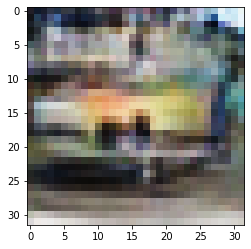

In [42]:
sampleCondGan(1)

In [36]:
cond_gan1.generator.save("upsc-cond-gan")

INFO:tensorflow:Assets written to: upsc-cond-gan/assets


## VAE

In [ ]:
batch_size = 32
num_channels = 3
num_classes = 10
image_size = 32
latent_dim = 128

In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

In [ ]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=((32, 32, discriminator_in_channels))),

            tf.keras.layers.Conv2D(
                filters=32, kernel_size=4, strides=(2, 2), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(
                filters=32, kernel_size=4, strides=(2, 2), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(
                filters=32, kernel_size=4, strides=(2, 2), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            # No activation
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
            tf.keras.layers.Reshape(target_shape=(latent_dim * 2,)),
        ]
        )


        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim + num_classes,)),
            tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(8, 8, 32)),  

            tf.keras.layers.UpSampling2D(size=(2, 2)),
            tf.keras.layers.Conv2D(192, (4, 4), padding='same', activation='relu'),
            layers.BatchNormalization(),

            tf.keras.layers.UpSampling2D(size=(2, 2)),
            tf.keras.layers.Conv2D(96, (4, 4), padding='same', activation='relu'),
            layers.BatchNormalization(),

            # No activation
            tf.keras.layers.Conv2D(3, (4, 4), padding='same', use_bias=False)
        ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(1, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x, real, one_hot_labels):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    z_comb = tf.concat([z, one_hot_labels], 1)
    x_logit = model.decode(z_comb)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=real)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, batch, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """

    real_images, one_hot_labels = batch


    image_one_hot_labels = one_hot_labels[:, :, None, None]
    image_one_hot_labels = tf.repeat(
      image_one_hot_labels, repeats=[image_size * image_size]
    )
    image_one_hot_labels = tf.reshape(
      image_one_hot_labels, (-1, image_size, image_size, num_classes)
    )
    X = tf.concat([real_images, image_one_hot_labels], -1)
    with tf.GradientTape() as tape:
        loss = compute_loss(model, X, real_images, one_hot_labels)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
epochs = 100
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 110

model = CVAE(latent_dim)

In [ ]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for batch in dataset: 
        train_step(model, batch, optimizer)
    end_time = time.time()
    print('Epoch: {}, time elapse for current epoch: {}'
    .format(epoch, end_time - start_time))

In [ ]:
def sampleCondVae():
    z = tf.random.normal(shape=(1, latent_dim))
    conditioned_array = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    conditioned_array = np.expand_dims(conditioned_array, axis=0)
    z_comb = tf.concat([z, conditioned_array], 1)
    picture = model.sample(z_comb)[0]
    plt.imshow(picture)
    plt.show()

In [ ]:
sampleCondVae()

In [ ]:
model.decoder.save("upsc-cond-vae")